# Initial Exploratory Data Analysis

In [12]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [13]:
DATA_DIR = "../sampled_images/2024-03-25-15-40-16"

image_files = []
for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            image_files.append(os.path.join(root, file))

print(f"Found {len(image_files)} images.")

Found 5 images.


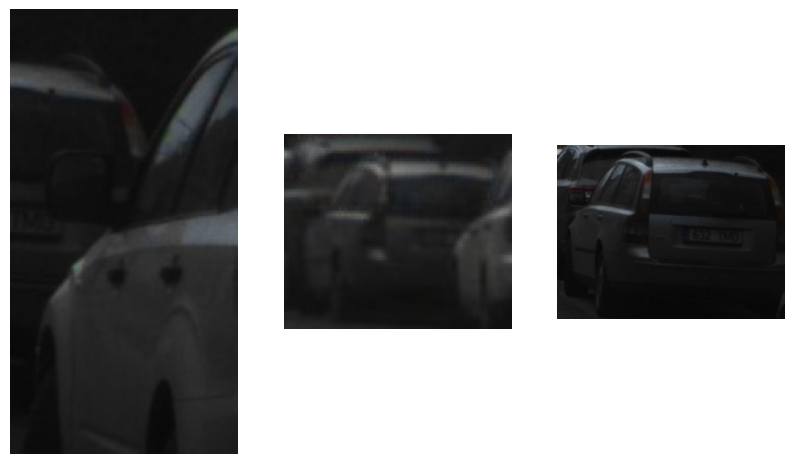

In [10]:
sample_files = random.sample(image_files, 3)

plt.figure(figsize=(10, 10))
for i, file in enumerate(sample_files):
    img = Image.open(file)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [11]:
widths, heights = [], []
for file in image_files:
    img = Image.open(file)
    widths.append(img.width)
    heights.append(img.height)

print(f"Image sizes: min={min(widths)}x{min(heights)}, max={max(widths)}x{max(heights)}, mean={int(np.mean(widths))}x{int(np.mean(heights))}")

Image sizes: min=83x71, max=355x275, mean=182x181


## Labeling Schema

- Left turn signal (on/off)
- Right turn signal (on/off)
- Hazard lights
- Tail lights (presence/absence)
- No visible lights

(Added no visible lights because of the above sample with all lights obscured by front vehicle)